In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer
import ELPH_Dim_Reducer
import ELPH_VAR_Transformer

from ELPH_RDNLVAR import RDNLVAR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')
# runs = ELPH_utils.load_runs(filename='../runs.npz')
runs = ELPH_utils.load_runs(filename='../runs_n_kmax=120.npz')

# runs = runs[:100:1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 120


runs[0] shape:  (120, 400)


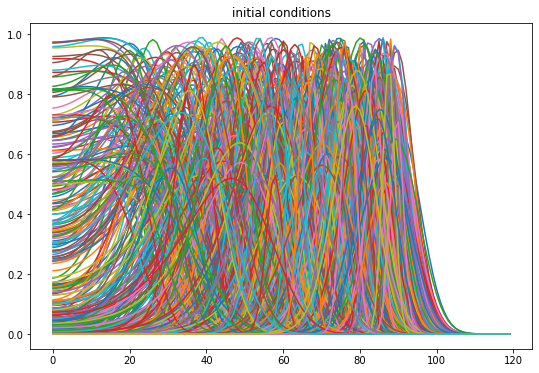

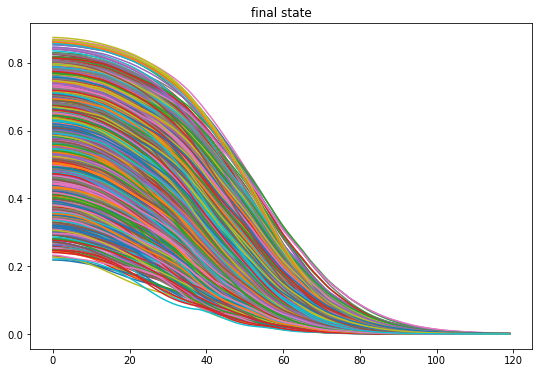

In [36]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (141, 399000)
target shape:  (30, 399000)
weights shape:  (141, 30)


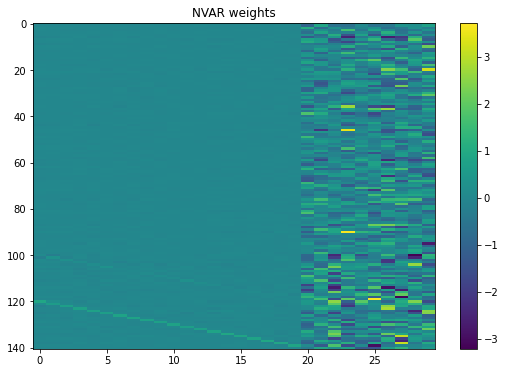

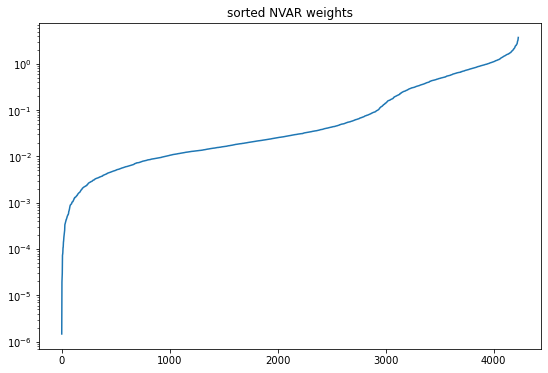

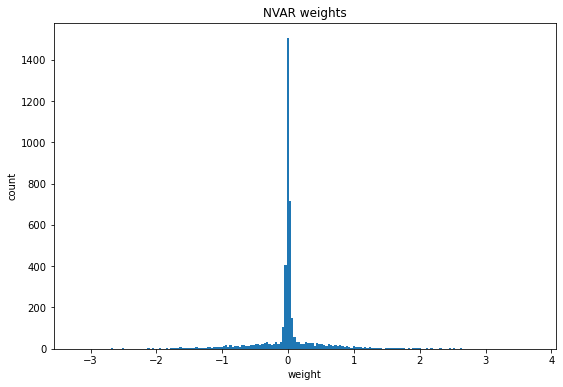

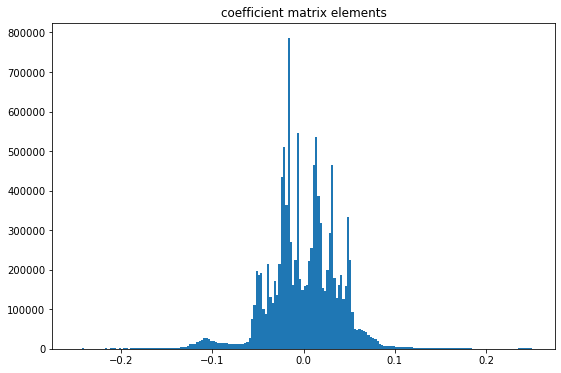

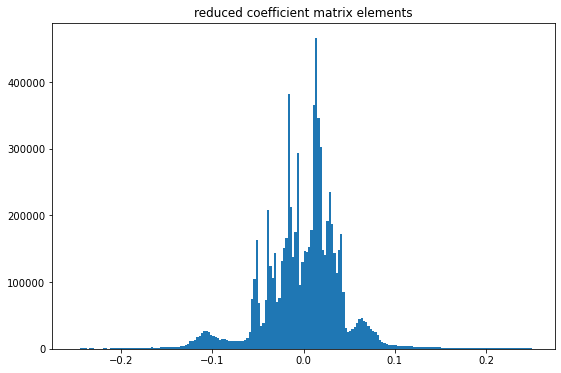

In [38]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.0)
scaler = ELPH_Scaler.normalize_scaler(0.5)
dim_reducer = ELPH_Dim_Reducer.SVD()

def sigmoid(x):
    return 2.0/(1.0 + np.exp(-x)) -1.0

activation_function=np.tanh

ELM_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=100, activation_function=activation_function)

model = RDNLVAR(runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=ELM_transformer)
model.print_status()

plt.imshow(model.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(model.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(model.coef_matrix[:model.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

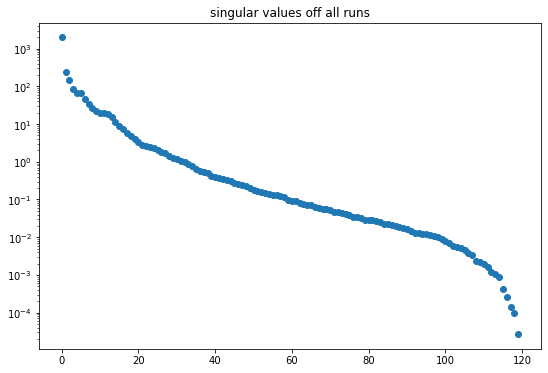

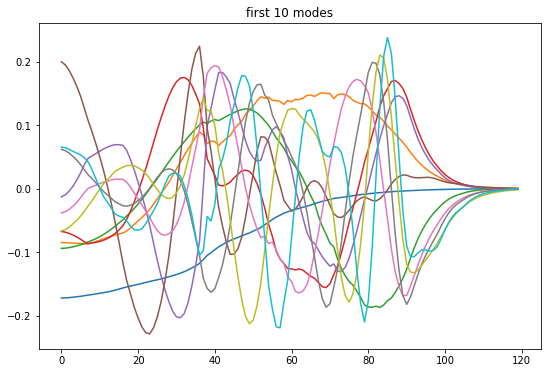

In [39]:
plt.semilogy(dim_reducer.S, 'o')
plt.title('singular values off all runs')
plt.show()

rdim = 10
for l in range(rdim):
  plt.plot(dim_reducer.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(rdim) + ' modes')
plt.show()

In [64]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.0)
scaler = ELPH_Scaler.normalize_scaler(0.5)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=200, seed=0)

train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
score_kwargs = {'norm':'std'}


m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.007786744551656689
0.002588781625750905
[0.012320261022906464, 0.008366164442338602, 0.006893923452835276, 0.006884709393577901, 0.004468664446625204]


rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (241, 398601)
target shape:  (30, 398601)
weights shape:  (241, 30)
std error:  0.00321927615923071
max error:  0.009175459624750082


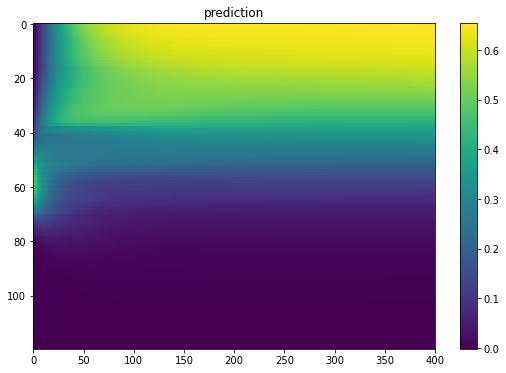

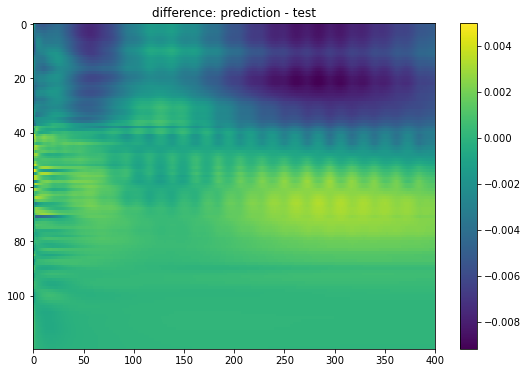

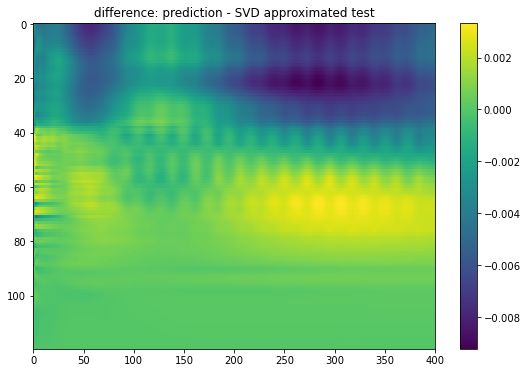

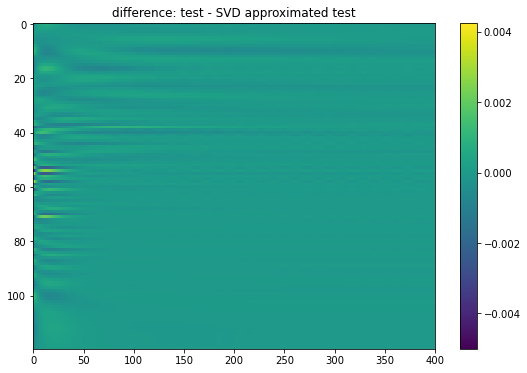

In [44]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.0)
scaler = ELPH_Scaler.normalize_scaler(0.5)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=200, activation_function=activation_function, seed=0)

train_runs = runs[::1]
test_run = train_runs.pop(85)

model.load_runs(train_runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)

model.print_status()


pred = model.predict_single_run(test_run)


print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max error: ', model.get_error(test_run, pred, norm='max') )


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


test_run_SVDapprx = dim_reducer.U[:,:30] @ dim_reducer.U[:,:30].T @ test_run

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()


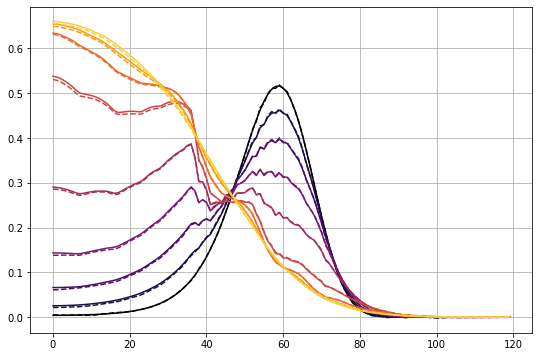

std error:  0.00321927615923071
max abs error:  0.009175459624750082


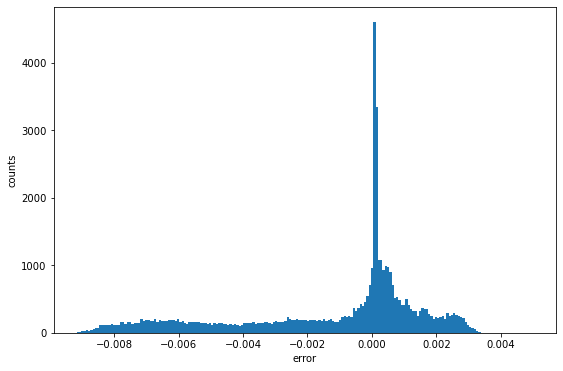

In [45]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [20]:
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=100, activation_function=activation_function, seed=0)

def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)

    
    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
    score_kwargs = {'norm':'max'}
    
    m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,1.0]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

optimizer.maximize(init_points=5, n_iter=100)

|   iter    |  target   |   aExp    | rel_scale |
-------------------------------------------------
|  1        | -0.02605  | -3.007    |  0.3326   |
|  2        | -0.04012  | -4.485    |  0.3198   |
|  3        | -0.03538  | -2.094    |  0.6728   |
|  4        | -0.03187  | -2.661    |  0.4647   |
|  5        | -0.03621  | -3.044    |  0.1073   |
|  6        | -0.04159  | -2.517    |  0.1309   |
|  7        | -0.02781  | -2.054    |  0.7418   |
|  8        | -0.03445  | -2.117    |  0.2626   |
|  9        | -0.02416  | -4.343    |  0.883    |
|  10       | -0.02996  | -2.736    |  0.7364   |
|  11       | -0.02551  | -4.789    |  0.9456   |
|  12       | -0.03179  | -2.867    |  0.9429   |
|  13       | -0.02972  | -2.956    |  0.8163   |
|  14       | -0.03605  | -2.871    |  0.1408   |
|  15       | -0.8989   | -4.302    |  0.4424   |
|  16       | -2.288    | -4.639    |  0.2157   |
|  17       | -0.06037  | -2.854    |  0.2969   |
|  18       | -0.03003  | -2.069    |  0.7511   |


KeyboardInterrupt: 

In [46]:
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=200, seed=0)

def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)

    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
    score_kwargs = {'norm':'std'}
    
    m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

scores = []

k = 1

for aExp in np.linspace(-5,-1,15):
    for rs in np.linspace(0.1,1.0,15):
        print(k)
        scores.append(get_score(aExp,rs))
        k += 1



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


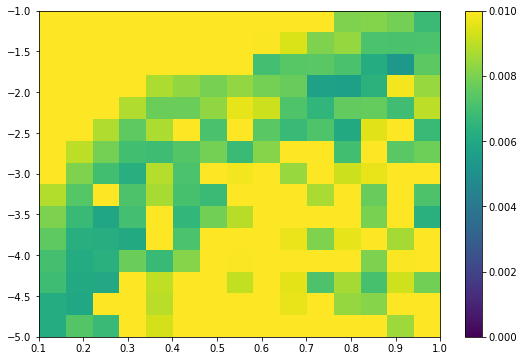

In [61]:


scrs = np.array(scores)
scrs = np.reshape(scrs,(15,15))


plt.imshow(-1.0*scrs, aspect='auto', origin='lower', vmin=0.00, vmax=0.01, extent=[0.1,1.0,-5,-1])
plt.colorbar()
plt.show()

